In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
import random
import os
import time

In [2]:
data = scipy.io.loadmat('./udata1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'U0', 'V0', 'U', 'V', 'P', 'P0'])

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

In [4]:
U = data["U"]
V = data["V"]
P = data["P"]
U.shape, V.shape, P.shape

((65, 65, 129), (65, 65, 129), (65, 65, 129))

In [5]:
x_star = np.linspace(0, 1, 65)
y_star = np.linspace(0, 1, 65)
xx, yy = np.meshgrid(x_star, y_star)

snap = 0
uu = U[:, :, snap]
vv = V[:, :, snap]
pp = P[:, :, snap]
x_star.shape

(65,)

<ipython-input-6-7e4a3fc4c71b>:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cax1)
<ipython-input-6-7e4a3fc4c71b>:19: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cax2)


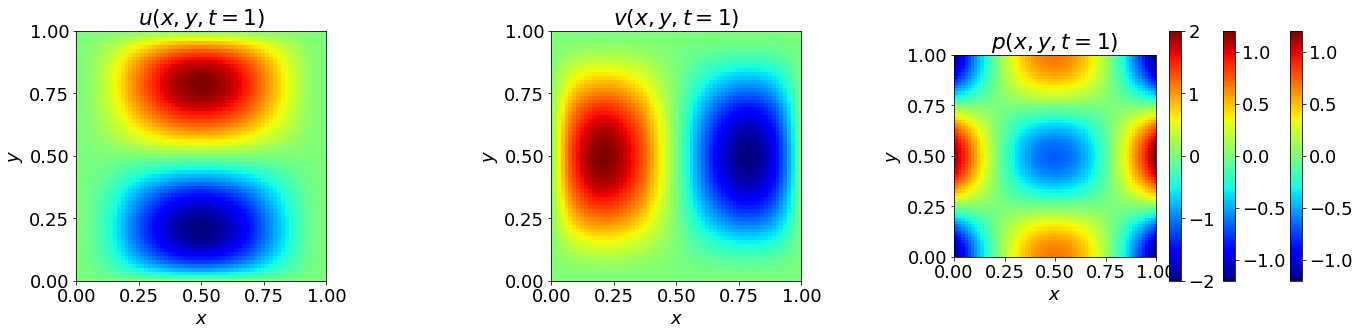

In [6]:
left, right, bottom, top = 0, 1, 0, 1

plt.rcParams.update({"font.size": 18})
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].pcolor(xx, yy, uu, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title(r'$u(x, y, t=1)$')
axes[0].set_xlim([left, right])
axes[0].set_ylim([bottom, top])
axes[0].set_xticks(np.linspace(left, right, 5))
axes[0].set_yticks(np.linspace(bottom, top, 5))
axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].pcolor(xx, yy, vv, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_title(r'$v(x, y, t=1)$')
axes[1].set_xlim([left, right])
axes[1].set_ylim([bottom, top])
axes[1].set_xticks(np.linspace(left, right, 5))
axes[1].set_yticks(np.linspace(bottom, top, 5))
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].pcolor(xx, yy, pp, cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x$')
axes[2].set_ylabel('$y$')
axes[2].set_title('$p(x, y, t=1)$')
axes[2].set_xlim([left, right])
axes[2].set_ylim([bottom, top])
axes[2].set_xticks(np.linspace(left, right, 5))
axes[2].set_yticks(np.linspace(bottom, top, 5))
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('uvp_t_1.png', dpi=100, bbox_inches='tight')
plt.show()

In [7]:
def p_exact_solution(t, x, y):
    return - (2 - np.pi * np.sin(np.pi * x)) * np.cos(2 * np.pi * y) * np.cos(2 * np.pi * t)

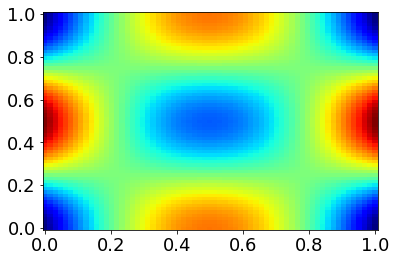

In [8]:
pp_exact = p_exact_solution(1., xx.reshape(-1), yy.reshape(-1))
pp_exact = pp_exact.reshape(xx.shape)
plt.pcolor(xx, yy, pp_exact, cmap='jet')

In [9]:
t_star = np.linspace(0,129,129).reshape((-1,1))
X_star = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)

N = X_star.shape[0]
T = t_star.shape[0]
print(T)

XX = np.tile(X_star[:,0:1], (1,T)) # N,T
YY = np.tile(X_star[:,1:2], (1,T)) # N,T
TT = np.tile(t_star, (1,N)).T # N,T

x = XX.flatten()[:, None]
y = YY.flatten()[:, None]
t = TT.flatten()[:, None]
u = U.flatten()[:, None]
v = V.flatten()[:, None]
p = P.flatten()[:, None]
x,u.max()

129


(array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]]),
 1.201629638671875)

In [10]:
domain = (0,1,0,1,0,129)
xmin , xmax ,ymin,ymax,tmin,tmax = domain
backbone_layers = [3] + [20]*6 + [2]
nn_lam_layers = [3] +[20]*4 + [2]
N_train = 4000
adam_iters = 1000
# adam_iters = 200000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [11]:
class DatasetNS:
    def __init__(self, domain):
        self.domain = domain

    def train_data(self, N_train, verbose=None):
        xmin, xmax, ymin, ymax, tmin, tmax = domain
        
        idx = np.random.choice(N * T, N_train, replace=False)
        x_train = x[idx, :]
        y_train = y[idx, :]
        t_train = t[idx, :]
        u_train = u[idx, :]
        v_train = v[idx, :]
        p_train = p[idx, :]

        return x_train, y_train, t_train, u_train, v_train, p_train
    

dataset = DatasetNS(domain)
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
print(x_train.shape, y_train.shape, t_train.shape, u_train.shape, v_train.shape, p_train.shape)

(4000, 1) (4000, 1) (4000, 1) (4000, 1) (4000, 1) (4000, 1)


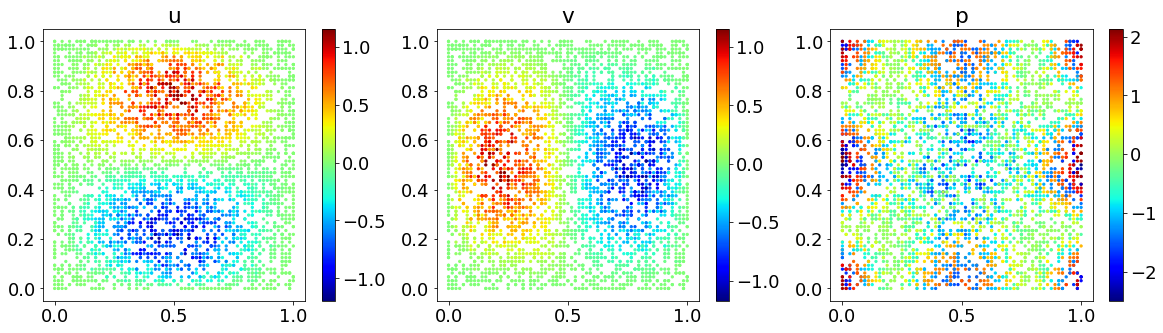

In [12]:
# 随即采样真实数据
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
plt.scatter(x_train, y_train, c=u_train, s=5, cmap='jet')
plt.title("u")
plt.colorbar()

plt.subplot(1,3,2)
plt.scatter(x_train, y_train, c=v_train, s=5, cmap='jet')
plt.title("v")
plt.colorbar()

plt.subplot(1,3,3)
plt.scatter(x_train, y_train, c=p_train, s=5, cmap='jet')
plt.title("p")
plt.colorbar()

In [13]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)


backbone = MLP(backbone_layers)
nn_lam = MLP(nn_lam_layers)

## PINN模型

In [14]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [15]:
"""PINN模型"""
class PINNNS(nn.Module):
    def __init__(self, backbone, nn_lam, mu=None, sigma=None):
        super(PINNNS, self).__init__()
        self.backbone = backbone
        self.nn_lam = nn_lam
        self.lam1 = torch.tensor([0.0], requires_grad=True)
        self.lam2 = torch.tensor([0.0], requires_grad=True)

        self.lam1 = torch.nn.Parameter(self.lam1)
        self.lam2 = torch.nn.Parameter(self.lam2)

        self.backbone = MLP(backbone_layers).to(device)
        self.nn_lam = MLP(nn_lam_layers).to(device)

        self.backbone.register_parameter('lam1', self.lam1)
        self.backbone.register_parameter('lam2', self.lam2)

        self.nn_lam.register_parameter('lam1', self.lam1)
        self.nn_lam.register_parameter('lam2', self.lam2)
        
        self.dataset = DatasetNS(domain)
        
#         self.bound1 = 1.
#         self.bound2 = 0.01
        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False

    def forward(self,X_res, u_star, v_star):
        f_u, f_v, u, v, p = self.net_NS(X_res)
        loss_u_data = torch.mean(f_u ** 2)
        loss_v_data = torch.mean(f_v ** 2)
        loss_u_res = torch.mean((u_star - u) ** 2)
        loss_v_res = torch.mean((v_star - v) ** 2)

        return loss_u_data, loss_v_data, loss_u_res, loss_v_res
    
    def update_train_data(self):
        """更新采样点"""
        self.x, self.y, self.t, self.u, self.v, self.p = self.dataset.train_data(N_train)
        
        
    def net_u(self,X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
        # return self.backbone(X_res)

    def net_NS(self,X_res):
        X_res.requires_grad_(True)

        pred = self.net_u(X_res)
        psi = pred[:,[0]].reshape(-1, 1)
        p = pred[:,[1]].reshape(-1, 1)
        
        psi.requires_grad_(True)
        p.requires_grad_(True)

        grad_psi = grad(psi,X_res)[0]
        u = grad_psi[:, [1]]
        v = - grad_psi[:, [0]]

        grad_u = grad(u, X_res)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_t = grad_u[:, [2]]
        u_xx = grad(u_x, X_res)[0][:, [0]]
        u_yy = grad(u_y, X_res)[0][:, [1]]
        
        grad_v = grad(v, X_res)[0]
        v_x = grad_v[:, [0]]
        v_y = grad_v[:, [1]]
        v_t = grad_v[:, [2]]
        v_xx = grad(v_x, X_res)[0][:, [0]]
        v_yy = grad(v_y, X_res)[0][:, [1]]
        
        grad_p = grad(p, X_res)[0]
        p_x = grad_p[:, [0]]
        p_y = grad_p[:, [1]]

        lam1 = self.lam1
        lam2 = self.lam2

        f_u = u_t + lam1 * (u*u_x + v*u_y) + p_x - lam2 * (u_xx + u_yy)
        f_v = v_t + lam1 * (u*v_x + v*v_y) + p_y - lam2 * (v_xx + v_yy)
        return f_u, f_v, u, v, p

pinn = PINNNS(backbone, nn_lam)

## Adam

In [16]:
"""Adam优化"""
dataset = DatasetNS(domain)  # 生成训练数据
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
t_train = torch.from_numpy(t_train).float().to(device)
u_train = torch.from_numpy(u_train).float().to(device)
v_train = torch.from_numpy(v_train).float().to(device)
p_train = torch.from_numpy(p_train).float().to(device)

X_res = torch.cat([x_train,y_train,t_train], dim=1)
# X_res = np.concatenate([x, y, t],1)
# X_res = torch.tensor(X_res)
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_lam, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)
optimizer_adam_lam = optim.Adam(pinn.nn_lam.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率
lr_sche_lam = optim.lr_scheduler.ExponentialLR(optimizer_adam_lam, gamma=0.9)
logger = {
    "loss": [],
    "loss_u_res": [],
    "loss_v_res": [],
    "loss_u_data": [],
    "loss_v_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    # 计算loss并更新网络 -------
    pinn.train()
    pinn.zero_grad()

    loss_u_data, loss_v_data,loss_u_res, loss_v_res = pinn(X_res,u_train,v_train)
    # loss = 100 * loss_res + 100 * loss_data
    loss = (loss_u_data + loss_v_data + loss_u_res + loss_v_res) * 100

    loss.backward()
    optimizer_adam.step()
    optimizer_adam_lam.step()
    # 计算loss并更新网络 -------

    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_u_data_valid, loss_v_data_valid, loss_u_res_valid, loss_v_res_valid = pinn(X_res,u_train,v_train)
        loss_valid = loss_u_data_valid + loss_v_data_valid + loss_u_res_valid + loss_v_res_valid

        logger["loss"].append(loss_valid.item())
        logger["loss_u_res"].append(loss_u_res_valid.item())
        logger["loss_v_res"].append(loss_v_res_valid.item())
        logger["loss_u_data"].append(loss_u_data_valid.item())
        logger["loss_v_data"].append(loss_v_data_valid.item())
        logger["iter"].append(it + 1)

        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it + 1, 'backbone_state': pinn.backbone.state_dict(),
                           'nn_lam_state': pinn.nn_lam.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()

        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it + 1:6d}/{adam_iters}\t' + \
                   f'loss:{loss.item():.2e}, loss_u_r:{loss_u_res.item():.2e}, loss_v_r:{loss_v_res.item():.2e}, loss_u_d:{loss_u_data.item():.2e} ,loss_v_d:{loss_v_data.item():.2e} ' + \
                   f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_u_res_valid.item():.2e}, loss_r:{loss_v_res_valid.item():.2e}, loss_u_d:{loss_u_data_valid.item():.2e}, loss_v_d:{loss_v_data_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
        pinn.update_train_data()

        # 衰减学习率
        if (it + 1) % 4000 == 0:
            lr_sche.step()
            lr_sche_lam.step()

forward with normalization, mu=[0.5030078291893005, 0.496031254529953, 65.15205383300781], sigma=[0.29420554637908936, 0.2930295467376709, 37.30864334106445]
Iter #    500/1000	loss:2.06e-01, loss_u_r:1.05e-03, loss_v_r:1.00e-03, loss_u_d:6.56e-06 ,loss_v_d:4.33e-06 Valid # loss:2.06e-03, loss_r:1.05e-03, loss_r:9.99e-04, loss_u_d:6.58e-06, loss_v_d:4.35e-06
Iter #   1000/1000	loss:1.20e-01, loss_u_r:6.22e-04, loss_v_r:5.61e-04, loss_u_d:8.33e-06 ,loss_v_d:7.37e-06 Valid # loss:1.19e-03, loss_r:6.22e-04, loss_r:5.61e-04, loss_u_d:3.89e-06, loss_v_d:4.44e-06


In [17]:
np.save("./logger.npy", logger)
model_state

{'iter': 1000,
 'backbone_state': OrderedDict([('lam1', tensor([-0.0003])),
              ('lam2', tensor([0.0001])),
              ('model.layer0.fc0.weight',
               tensor([[ 0.0791,  0.4077,  0.0538],
                       [-0.4534, -0.4783,  0.1800],
                       [ 0.4232,  0.1389,  0.0227],
                       [-0.4757,  0.3803,  0.2890],
                       [ 0.3052, -0.1547,  0.0828],
                       [-0.0208,  0.6600,  0.0730],
                       [ 0.3524, -0.2364,  0.1242],
                       [ 0.2982,  0.3246, -0.2132],
                       [-0.3670, -0.1507,  0.1354],
                       [-0.3543,  0.2973,  0.3140],
                       [-0.2862,  0.3008,  0.1881],
                       [ 0.6892,  0.5480, -0.0233],
                       [-0.5247, -0.1494, -0.0110],
                       [ 0.1776, -0.3913,  0.2996],
                       [ 0.0008, -0.4292,  0.1043],
                       [-0.3629,  0.6268, -0.0526],
        

## 可视化

In [18]:
# # # 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

# mu = X_res.mean(dim=0)
# sigma = X_res.std(dim=0)

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_lam, mu, sigma)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])
pinn.eval()

data = scipy.io.loadmat('udata1.mat')

U0 = data['U0']  # (16641, 129)
V0 = data['V0']  # (16641, 129)
P0 = data['P0']  # (4225, 65)

U = data['U']  # (65, 65, 129)
V = data['V'] # (65, 65, 129)
P = data['P'] # (65, 65, 129)

x_star = np.linspace(1, 10, 65).reshape((-1,1))
y_star = np.linspace(-2, 2, 65).reshape((-1,1))
t_star = np.linspace(0,129,129).reshape((-1,1))
xx, yy = np.meshgrid(x_star,y_star)
X_star = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)

N = X_star.shape[0]
T = t_star.shape[0]

XX = np.tile(xx, (1,T)) # N,T
YY = np.tile(yy, (1,T)) # N,T
TT = np.tile(t_star, (1,N)).T # N,T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = U.flatten()[:, None]  # NT x 1
v = V.flatten()[:, None]  # NT x 1
p = P.flatten()[:, None]  # NT x 1

x = torch.tensor(x)
y = torch.tensor(y)
t = torch.tensor(t)

pinn = pinn.cpu().double()
# pred = pinn.net_u(torch.cat((x,y,t),1)).detach().numpy()
# u_pred = pred[:,[0]]
# v_pred = pred[:,[1]]
# p_pred = pred[:,[2]]
# # u_pred = u_pred.reshape(TT.shape)

# u_error = np.linalg.norm(u_pred - u) / np.linalg.norm(u) 
# print('Relative l2 error of u: {:.3e}'.format(u_error))

lam1_star = 1
lam2_star = 0.01

t_star.shape,N,T
# U[:,:,100]
TT.shape

forward with normalization, mu=[0.5030078291893005, 0.496031254529953, 65.15205383300781], sigma=[0.29420554637908936, 0.2930295467376709, 37.30864334106445]


(4225, 129)

In [19]:
model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])

snap = np.array([100])
x_star = X_star[:, 0:1]
y_star = X_star[:, 1:2]
t_star = TT[:,snap]

u_star = U[:, :, snap]
v_star = V[:, :, snap]
p_star = P[:,:,snap]

# Prediction
x_star = torch.tensor(x_star)
y_star = torch.tensor(y_star)
t_star = torch.tensor(t_star)
u_star = torch.tensor(u_star.flatten()[:, None])
v_star = torch.tensor(v_star.flatten()[:, None])
p_star = torch.tensor(p_star.flatten()[:, None])

X = torch.cat([x_star,y_star,t_star], dim=1)

X_res = pinn.net_NS(X)
X_res

(tensor([[-0.0005],
         [-0.0009],
         [-0.0013],
         ...,
         [ 0.0005],
         [ 0.0005],
         [ 0.0004]], dtype=torch.float64, grad_fn=<SubBackward0>),
 tensor([[ 0.0006],
         [ 0.0010],
         [ 0.0010],
         ...,
         [-0.0011],
         [-0.0011],
         [-0.0010]], dtype=torch.float64, grad_fn=<SubBackward0>),
 tensor([[0.0200],
         [0.0112],
         [0.0022],
         ...,
         [0.0266],
         [0.0246],
         [0.0228]], dtype=torch.float64, grad_fn=<IndexBackward0>),
 tensor([[-0.0222],
         [ 0.0089],
         [ 0.0388],
         ...,
         [ 0.0037],
         [ 0.0034],
         [ 0.0030]], dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor([[-0.0070],
         [-0.0070],
         [-0.0071],
         ...,
         [-0.0136],
         [-0.0135],
         [-0.0135]], dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>))

In [20]:
"""计算error"""
u_pred = torch.tensor(X_res[2])
v_pred = torch.tensor(X_res[3])
p_pred = torch.tensor(X_res[4])

u_pred =u_pred.flatten()[:, None].detach().cpu().numpy()
v_pred =v_pred.flatten()[:, None].detach().cpu().numpy()
p_pred =p_pred.flatten()[:, None].detach().cpu().numpy()  
lam1_pred = pinn.lam1.detach().cpu().numpy()
lam2_pred = pinn.lam2.detach().cpu().numpy()

print('lam1_pred:',lam1_pred)
print('lam2_pred:',lam2_pred)
print('u_star:',u_star)
print('u_pred:',u_pred)
print('v_star:',v_star)
print('v_pred:',v_pred)
print('p_star:',p_star)
print('p_pred:',p_pred)

# Error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

error_lambda_1 = np.abs(lam1_pred - lam1_star) /lam1_star * 100
error_lambda_2 = np.abs(lam2_pred - lam2_star) / lam2_star * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))    

lam1_pred: [-0.00031898]
lam2_pred: [0.00014029]
u_star: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=torch.float64)
u_pred: [[0.02004883]
 [0.01115139]
 [0.00220483]
 ...
 [0.02655665]
 [0.02462229]
 [0.022831  ]]
v_star: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=torch.float64)
v_pred: [[-0.02218754]
 [ 0.00885434]
 [ 0.03880278]
 ...
 [ 0.00372957]
 [ 0.00336113]
 [ 0.00302056]]
p_star: tensor([[-2.0000],
        [-1.8441],
        [-1.6868],
        ...,
        [-1.6868],
        [-1.8441],
        [-2.0000]], dtype=torch.float64)
p_pred: [[-0.00696545]
 [-0.0069952 ]
 [-0.00705883]
 ...
 [-0.01356849]
 [-0.01354228]
 [-0.01351729]]
Error u: 9.794826e-01
Error v: 9.565102e-01
Error p: 1.005807e+00
Error l1: 100.03190%
Error l2: 98.59710%


<ipython-input-20-e015588fc35f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_pred = torch.tensor(X_res[2])
<ipython-input-20-e015588fc35f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_pred = torch.tensor(X_res[3])
<ipython-input-20-e015588fc35f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_pred = torch.tensor(X_res[4])


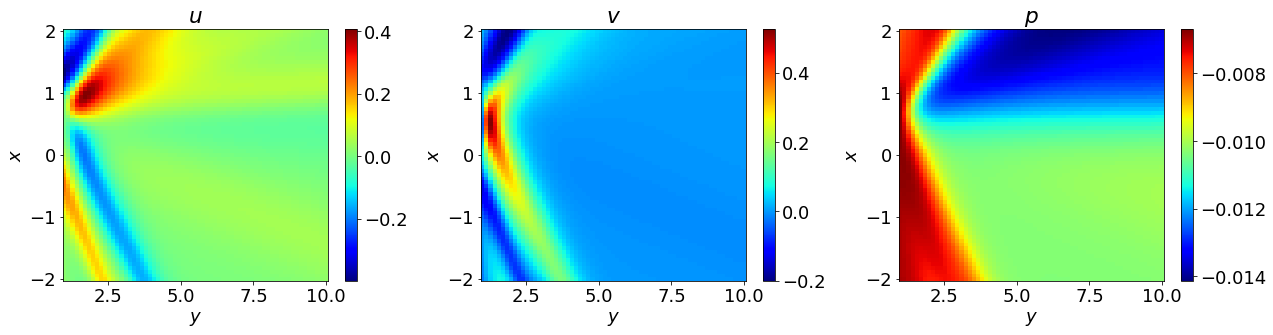

In [21]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.colorbar()
# plt.clim([u.min(),u.max()])
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'$u$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, v_pred.reshape(xx.shape), cmap='jet')
plt.colorbar()
# plt.clim([v.min(),v.max()])
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'$v$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, p_pred.reshape(xx.shape), cmap='jet')
plt.colorbar()
# plt.clim([p.min(),p.max()])
plt.xlabel('$y$')
plt.ylabel('$x$')
plt.title(r'$p$')
plt.tight_layout()